In [1]:
import random
import numpy as np
import os

# Set environment variable for Python hashing (affects some randomness in dict/set ordering)
os.environ["PYTHONHASHSEED"] = "42"

# Python's built-in random module
random.seed(42)

# NumPy random
np.random.seed(42)

# If using scikit-learn
import sklearn
sklearn.utils.check_random_state(42)



RandomState(MT19937) at 0x23775721240

## Imports + global CV setup

### Loads libraries, defines random seed, and sets up stratified 5-fold CV used inside GridSearch.

In [2]:
# -*- coding: utf-8 -*-
# Academic-grade, leakage-safe multi-model pipeline
# - Train/Val/Test split
# - SMOTE *inside* CV via imblearn.Pipeline (no leakage)
# - CV tuning (ROC AUC)
# - Threshold chosen on VALIDATION via Youden's J
# - Final evaluation on TEST only once
# - ROC + Calibration plots (optional)
# - Bootstrapped Confidence Intervals and Std for all metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, average_precision_score, brier_score_loss
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.pipeline import Pipeline as ImbPipeline   # IMPORTANT: imblearn pipeline
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


## Load dataset + define X/y

### Reads CSV, drops identifier/unused columns, splits into features X and label y

In [3]:
# -----------------------
# 1) Load & prepare data
# -----------------------
df = pd.read_csv("transformed_patient_data.csv")
df = df.drop(['Patient_ID', 'Adjusted AF for CRI'], axis=1, errors='ignore')

X = df.drop(columns=['class'])
y = df['class']


## Train/Validation/Test split (no SMOTE here)

### Creates leakage-safe splits: 70% train, 15% val, 15% test with stratification.

In [4]:
# ---------------------------------------
# 2) Train / Val / Test split (no SMOTE)
# ---------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE
)

print("Class distribution (train/val/test):")
for name, arr in [('train', y_train), ('val', y_val), ('test', y_test)]:
    print(f"{name}:\n{arr.value_counts()}\n")


Class distribution (train/val/test):
train:
class
1    235
0     65
Name: count, dtype: int64

val:
class
1    50
0    14
Name: count, dtype: int64

test:
class
1    51
0    14
Name: count, dtype: int64



## Helper: Youden’s J threshold selection

### Computes ROC curve on validation probs, picks threshold that maximizes (TPR − FPR), with guard rails.

In [5]:
# --------------------------------------------------------
# 3) Helpers
# --------------------------------------------------------
def youden_threshold(y_true, probs):
    fpr, tpr, thr = roc_curve(y_true, probs)
    j = tpr - fpr
    idx = np.argmax(j)
    t = thr[idx]
    # guard rails
    if np.isnan(t) or t <= 0 or t >= 1:
        t = 0.5
    return float(t)


## Helper: Bootstrap CI for metrics

### Resamples test/val predictions n_boot times and returns mean/std/CI for a metric

In [6]:
def bootstrap_ci(y_true, probs, metric_func, thr=0.5, n_boot=1000, ci=95, random_state=42):
    """
    Compute bootstrap mean, std, and CI for a metric.
    metric_func: function(y_true, probs, thr) -> float
    """
    rng = np.random.RandomState(random_state)
    stats = []
    n = len(y_true)

    # Ensure numpy arrays for positional indexing
    y_true = np.asarray(y_true)
    probs = np.asarray(probs)

    for _ in range(n_boot):
        idx = rng.choice(np.arange(n), size=n, replace=True)
        stats.append(metric_func(y_true[idx], probs[idx], thr))

    stats = np.array(stats)
    mean = np.mean(stats)
    std = np.std(stats)
    lower = np.percentile(stats, (100 - ci) / 2)
    upper = np.percentile(stats, 100 - (100 - ci) / 2)
    return {"mean": mean, "std": std, "ci": (lower, upper)}


## Summarise metrics + bootstrap CIs

### Produces point estimates + confusion matrix + bootstrap CIs for accuracy/AUC/AP/precision/recall/Brier.

In [7]:
def summarise(y_true, probs, thr):
    pred = (probs >= thr).astype(int)

    # Define metric functions
    def acc_func(y, p, t): return accuracy_score(y, (p >= t).astype(int))
    def auc_func(y, p, t): return roc_auc_score(y, p)
    def ap_func(y, p, t): return average_precision_score(y, p)
    def prec_func(y, p, t): 
        return classification_report(y, (p >= t).astype(int),
                                     output_dict=True, zero_division=0)["1"]["precision"]
    def rec_func(y, p, t): 
        return classification_report(y, (p >= t).astype(int),
                                     output_dict=True, zero_division=0)["1"]["recall"]
    def brier_func(y, p, t): return brier_score_loss(y, p)

    # Point estimates
    metrics = {
        "acc": acc_func(y_true, probs, thr),
        "auc": auc_func(y_true, probs, thr),
        "ap": ap_func(y_true, probs, thr),
        "prec1": prec_func(y_true, probs, thr),
        "rec1": rec_func(y_true, probs, thr),
        "brier": brier_func(y_true, probs, thr),
        "cm": confusion_matrix(y_true, pred),
    }

    # Bootstrap CIs & std
    metrics_ci = {
        "acc_ci": bootstrap_ci(y_true, probs, acc_func, thr),
        "auc_ci": bootstrap_ci(y_true, probs, auc_func, thr),
        "ap_ci": bootstrap_ci(y_true, probs, ap_func, thr),
        "prec1_ci": bootstrap_ci(y_true, probs, prec_func, thr),
        "rec1_ci": bootstrap_ci(y_true, probs, rec_func, thr),
        "brier_ci": bootstrap_ci(y_true, probs, brier_func, thr),
    }

    return {**metrics, **metrics_ci}


## Model pipelines + hyperparameter grids (SMOTE inside CV folds)

### Defines each model as an imblearn Pipeline so SMOTE happens inside CV folds, avoiding leakage.

In [8]:
# --------------------------------------------------------
# 4) Models-as-Pipelines with SMOTE inside CV folds
# --------------------------------------------------------
model_spaces = {
    "RandomForest": {
        "pipe": ImbPipeline([
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf", RandomForestClassifier(random_state=RANDOM_STATE))
        ]),
        "params": {
            "clf__n_estimators": [100, 200, 400],
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 4],
        },
    },
    "GradientBoosting": {
        "pipe": ImbPipeline([
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
        ]),
        "params": {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1, 0.2],
            "clf__max_depth": [2, 3],
        },
    },
    "LogisticRegression": {
        "pipe": ImbPipeline([
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=1000, solver="lbfgs", random_state=RANDOM_STATE))
        ]),
        "params": {
            "clf__C": [0.1, 1.0, 3.0, 10.0],
            "clf__penalty": ["l2"],
        },
    },
    "SVM_RBF": {
        "pipe": ImbPipeline([
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("scaler", StandardScaler()),
            ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
        ]),
        "params": {
            "clf__C": [0.5, 1, 3, 10],
            "clf__gamma": ["scale", 0.1, 0.01],
        },
    },
    "KNN": {
        "pipe": ImbPipeline([
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier())
        ]),
        "params": {
            "clf__n_neighbors": [3, 5, 7, 11],
            "clf__weights": ["uniform", "distance"],
            "clf__p": [1, 2],
        },
    },
}


## Training loop: GridSearch on train → threshold on val → final test eval


- For each model: tune on TRAIN only via CV AUC

- Choose threshold on VAL (Youden) once

- Evaluate final performance on TEST once

- Store results + fitted artifacts

In [9]:
# --------------------------------------------------------
# 5) Inner CV tuning on TRAIN only; VAL threshold; TEST eval
# --------------------------------------------------------
results = []
fitted = {}

for name, spec in model_spaces.items():
    print(f"\n=== {name}: GridSearchCV (Stratified 5-fold, scoring=roc_auc) ===")
    gs = GridSearchCV(
        estimator=spec["pipe"],
        param_grid=spec["params"],
        scoring="roc_auc",
        cv=CV,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)
    print("Best params:", gs.best_params_)
    best_pipe = gs.best_estimator_

    # Validation probs & threshold (picked ONCE here)
    val_probs = best_pipe.predict_proba(X_val)[:, 1]
    thr = youden_threshold(y_val, val_probs)
    print(f"Chosen threshold (val, Youden): {thr:.3f}")

    # Summaries on VAL
    s_val = summarise(y_val, val_probs, thr)

    # Final TEST evaluation
    test_probs = best_pipe.predict_proba(X_test)[:, 1]
    s_test = summarise(y_test, test_probs, thr)

    results.append({
        "model": name,
        "threshold": thr,

        # Validation metrics
        "val_auc": s_val["auc"], "val_auc_std": s_val["auc_ci"]["std"], "val_auc_ci": s_val["auc_ci"]["ci"],
        "val_ap": s_val["ap"], "val_ap_std": s_val["ap_ci"]["std"], "val_ap_ci": s_val["ap_ci"]["ci"],
        "val_acc": s_val["acc"], "val_acc_std": s_val["acc_ci"]["std"], "val_acc_ci": s_val["acc_ci"]["ci"],
        "val_prec1": s_val["prec1"], "val_prec1_std": s_val["prec1_ci"]["std"], "val_prec1_ci": s_val["prec1_ci"]["ci"],
        "val_rec1": s_val["rec1"], "val_rec1_std": s_val["rec1_ci"]["std"], "val_rec1_ci": s_val["rec1_ci"]["ci"],
        "val_brier": s_val["brier"], "val_brier_std": s_val["brier_ci"]["std"], "val_brier_ci": s_val["brier_ci"]["ci"],

        # Test metrics
        "test_auc": s_test["auc"], "test_auc_std": s_test["auc_ci"]["std"], "test_auc_ci": s_test["auc_ci"]["ci"],
        "test_ap": s_test["ap"], "test_ap_std": s_test["ap_ci"]["std"], "test_ap_ci": s_test["ap_ci"]["ci"],
        "test_acc": s_test["acc"], "test_acc_std": s_test["acc_ci"]["std"], "test_acc_ci": s_test["acc_ci"]["ci"],
        "test_prec1": s_test["prec1"], "test_prec1_std": s_test["prec1_ci"]["std"], "test_prec1_ci": s_test["prec1_ci"]["ci"],
        "test_rec1": s_test["rec1"], "test_rec1_std": s_test["rec1_ci"]["std"], "test_rec1_ci": s_test["rec1_ci"]["ci"],
        "test_brier": s_test["brier"], "test_brier_std": s_test["brier_ci"]["std"], "test_brier_ci": s_test["brier_ci"]["ci"],

        "best_params": gs.best_params_,
    })

    fitted[name] = {
        "pipe": best_pipe,
        "val_probs": val_probs, "test_probs": test_probs,
        "val_thr": thr,
        "val_cm": s_val["cm"], "test_cm": s_test["cm"],
    }



=== RandomForest: GridSearchCV (Stratified 5-fold, scoring=roc_auc) ===
Best params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}
Chosen threshold (val, Youden): 0.685

=== GradientBoosting: GridSearchCV (Stratified 5-fold, scoring=roc_auc) ===
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 2, 'clf__n_estimators': 100}
Chosen threshold (val, Youden): 0.348

=== LogisticRegression: GridSearchCV (Stratified 5-fold, scoring=roc_auc) ===
Best params: {'clf__C': 10.0, 'clf__penalty': 'l2'}
Chosen threshold (val, Youden): 0.468

=== SVM_RBF: GridSearchCV (Stratified 5-fold, scoring=roc_auc) ===
Best params: {'clf__C': 10, 'clf__gamma': 0.1}
Chosen threshold (val, Youden): 0.291

=== KNN: GridSearchCV (Stratified 5-fold, scoring=roc_auc) ===
Best params: {'clf__n_neighbors': 11, 'clf__p': 1, 'clf__weights': 'distance'}
Chosen threshold (val, Youden): 0.373


## Results table + confusion matrices

### Builds a DataFrame, sorts by test AUC, prints selected columns, and prints confusion matrices for val/test.

In [10]:
# --------------------------------------------------------
# 6) Tabulate & print results (sorted by TEST AUC)
# --------------------------------------------------------
results_df = pd.DataFrame(results).sort_values("test_auc", ascending=False)
print("\n\n=== Model comparison (sorted by TEST AUC) ===")
print(results_df[[
    "model","threshold",
    "val_auc","val_auc_std","val_auc_ci",
    "test_auc","test_auc_std","test_auc_ci",
    "val_acc","val_acc_std","val_acc_ci",
    "test_acc","test_acc_std","test_acc_ci",
]])

print("\nConfusion matrices (validation, then test) at chosen thresholds:")
for name in results_df["model"]:
    print(f"\n{name}:\nVAL\n{fitted[name]['val_cm']}\nTEST\n{fitted[name]['test_cm']}")




=== Model comparison (sorted by TEST AUC) ===
                model  threshold   val_auc  val_auc_std  \
1    GradientBoosting   0.348469  0.918571     0.036419   
0        RandomForest   0.685471  0.908571     0.037888   
3             SVM_RBF   0.290696  0.651429     0.089394   
2  LogisticRegression   0.468023  0.628571     0.089372   
4                 KNN   0.372792  0.585714     0.090575   

                                  val_auc_ci  test_auc  test_auc_std  \
1   (0.8362012173290368, 0.9765828266402715)  0.843137      0.063676   
0   (0.8221759259259259, 0.9699624530663329)  0.843137      0.065240   
3   (0.4621666976298498, 0.8190396158463384)  0.697479      0.086337   
2   (0.4509426847662142, 0.7933933573429373)  0.606443      0.080149   
4  (0.39362745098039215, 0.7600357142857143)  0.586835      0.075088   

                                 test_auc_ci   val_acc  val_acc_std  \
1   (0.7023214285714287, 0.9482186624649859)  0.875000     0.041264   
0    (0.69821183281004

## ROC curves on test set

### Plots ROC for every model using test probabilities (no refitting).

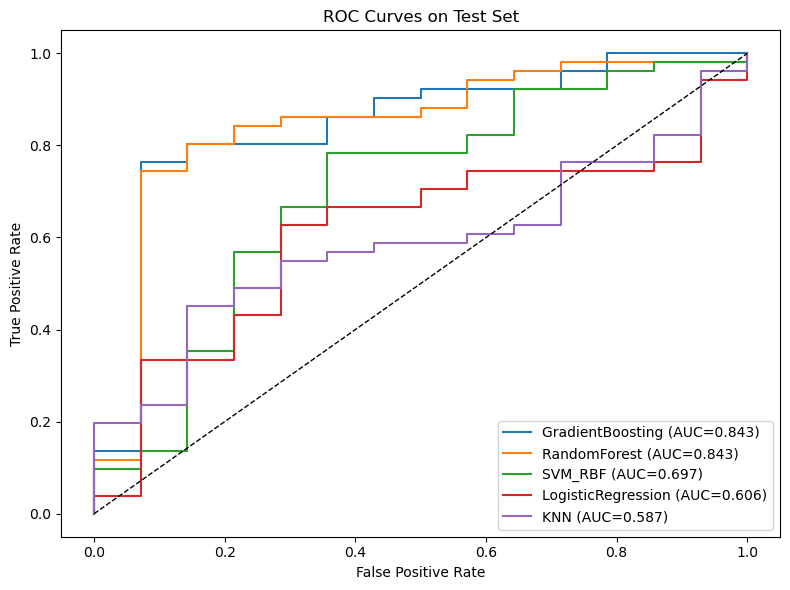

In [12]:
# --------------------------------------------------------
# 7) Optional: ROC on TEST (single pass, no refits)
# --------------------------------------------------------
plt.figure(figsize=(8, 6))
for name in results_df["model"]:
    probs = fitted[name]["test_probs"]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Test Set")
plt.legend()
plt.tight_layout()
plt.show()



## Feature importances:

If the classifier supports built-in feature_importances_ (tree models like RF/GB), it uses that. Otherwise, it computes permutation importance on the test set as a fallback. Renames features for the plot.

Sorts and plots the most important features.

Best model: GradientBoosting


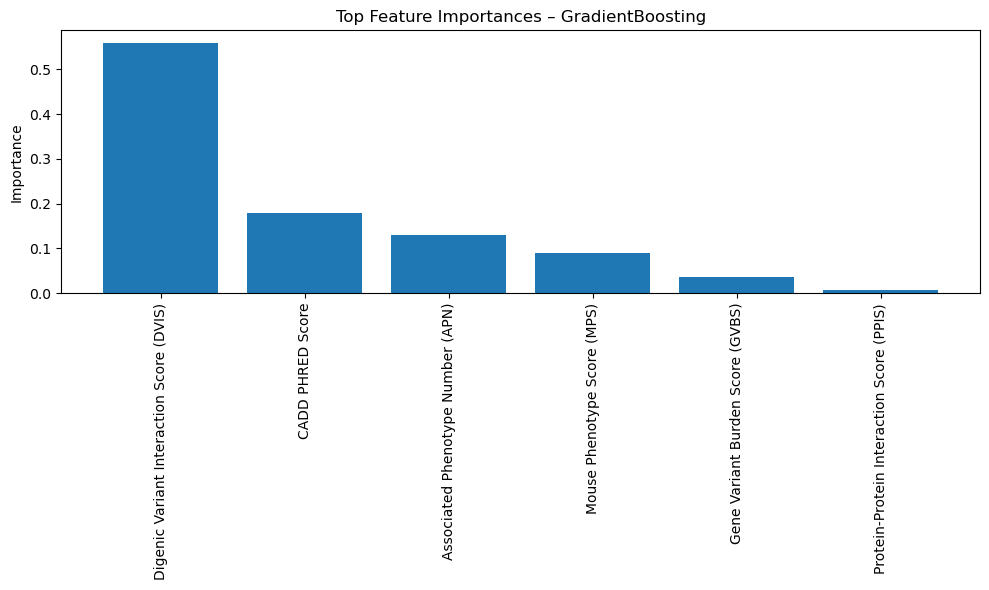

In [14]:
from sklearn.inspection import permutation_importance

# =========================
# 1) Pick the best model
# =========================
# results_df is already sorted by test_auc descending in your pipeline,
# so .iloc[0] picks the top-performing model.
best_model_name = results_df.iloc[0]["model"]
best_pipe = fitted[best_model_name]["pipe"]

print(f"Best model: {best_model_name}")

# =========================
# 2) Define feature-name mapping (raw column -> display name)
# =========================
# Any feature not found in this dictionary will keep its original name.
feature_name_map = {
    "Phenotype": "Mouse Phenotype Score (MPS)",
    "gene_score": "Gene Variant Burden Score (GVBS)",
    "PH": "Associated Phenotype Number (APN)",
    "CADD_PHRED": "CADD PHRED Score",
    "Compound_Het_Score": "Digenic Variant Interaction Score (DVIS)",
    "Compound Het Score": "Digenic Variant Interaction Score (DVIS)",  # fallback if spaced
    "CompoundHetScore": "Digenic Variant Interaction Score (DVIS)",    # fallback if variant naming
    "DCs_score": "Protein-Protein Interaction Score (PPIS)",
}

# =========================
# 3) Get feature importances
# =========================
# Your models are stored inside an imblearn Pipeline under the step "clf".
# For tree-based classifiers, sklearn exposes feature_importances_ directly.
# For other models, we fallback to permutation importance on X_test, y_test.
clf = best_pipe.named_steps["clf"]

if hasattr(clf, "feature_importances_"):
    # Tree-based model (RandomForest, GradientBoosting)
    importances = clf.feature_importances_
    feat_names = X.columns
else:
    # Permutation importance (model-agnostic):
    # Measures how much performance drops when each feature is shuffled.
    print("Model does not support feature_importances_. Using permutation importance...")
    result = permutation_importance(
        best_pipe, X_test, y_test,
        n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1
    )
    importances = result.importances_mean
    feat_names = X.columns

# =========================
# 4) Apply your renamed feature labels for visualization
# =========================
feat_names_pretty = np.array([feature_name_map.get(f, f) for f in feat_names])

# =========================
# 5) Sort features by importance (descending)
# =========================
indices = np.argsort(importances)[::-1]
feat_names_sorted = feat_names_pretty[indices]
importances_sorted = importances[indices]

# =========================
# 6) Plot top 20 feature importances
# =========================
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances_sorted[:20])), importances_sorted[:20], align="center")
plt.xticks(range(len(importances_sorted[:20])), feat_names_sorted[:20], rotation=90)
plt.title(f"Top Feature Importances – {best_model_name}")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


## Evaluation dashboard for top model on the test set.


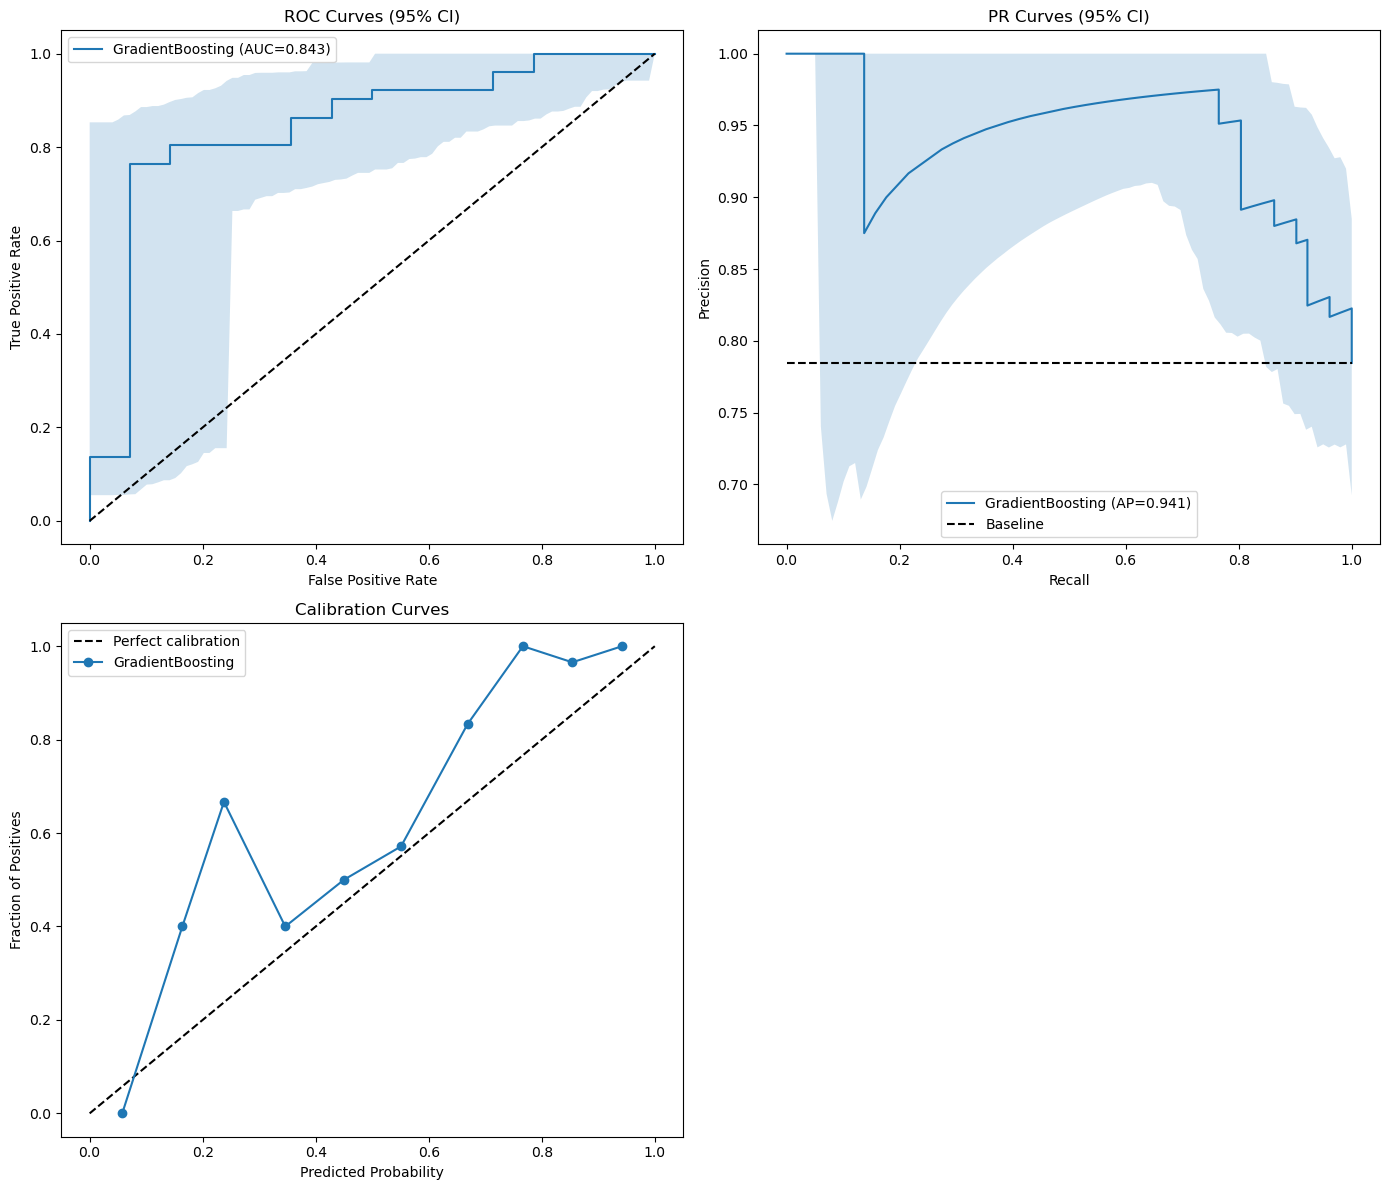

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay,
)
from sklearn.calibration import calibration_curve


# ============================================================
# 1) Bootstrap helper: ROC/PR curve mean + 95% confidence band
# ------------------------------------------------------------
# We resample the test set with replacement (bootstrap), compute the curve
# each time, and interpolate onto a fixed grid (100 points) so curves align.
# Then we summarize the distribution at each grid point using percentiles.
# ============================================================
def bootstrap_curve(y_true, probs, curve_func, n_boot=500, random_state=42):
    """
    Bootstrap ROC or PR curve.

    Parameters
    ----------
    y_true : array-like
        True labels (0/1).
    probs : array-like
        Predicted probabilities for class 1.
    curve_func : {'roc', 'pr'}
        Which curve to bootstrap.
    n_boot : int
        Number of bootstrap samples.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    base_points : ndarray (100,)
        Common x-axis grid (FPR for ROC, Recall for PR).
    mean : ndarray (100,)
        Mean curve across bootstrap runs.
    lower : ndarray (100,)
        2.5th percentile (lower 95% CI bound).
    upper : ndarray (100,)
        97.5th percentile (upper 95% CI bound).
    """
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true)
    probs = np.asarray(probs)
    n = len(y_true)

    # Common grid for interpolation
    base_points = np.linspace(0, 1, 100)
    values = []

    for _ in range(n_boot):
        # Resample indices with replacement
        idx = rng.choice(np.arange(n), size=n, replace=True)
        y_b = y_true[idx]
        p_b = probs[idx]

        # Compute curve on bootstrap sample, then interpolate onto common grid
        if curve_func == "roc":
            fpr, tpr, _ = roc_curve(y_b, p_b)
            v = np.interp(base_points, fpr, tpr)

        elif curve_func == "pr":
            prec, rec, _ = precision_recall_curve(y_b, p_b)
            # recall typically decreases -> reverse to make it increasing for interp
            v = np.interp(base_points, rec[::-1], prec[::-1])

        else:
            raise ValueError("curve_func must be 'roc' or 'pr'")

        values.append(v)

    values = np.array(values)
    mean = values.mean(axis=0)
    lower = np.percentile(values, 2.5, axis=0)
    upper = np.percentile(values, 97.5, axis=0)
    return base_points, mean, lower, upper


# ============================================================
# 2) Select top model to plot in the dashboard
# ------------------------------------------------------------
# Assumes results_df is already sorted best -> worst.
# ============================================================
top_models = results_df["model"].values[:1]


# ============================================================
# 3) Create the 2x2 dashboard canvas
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))


# ============================================================
# 4) Panel (0,0): ROC Curves with AUC + 95% CI bands
# ============================================================
for model in top_models:
    # Predicted probabilities on the test set
    probs = fitted[model]["test_probs"]

    # ROC curve + AUC
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = auc(fpr, tpr)
    axes[0, 0].plot(fpr, tpr, label=f"{model} (AUC={auc_score:.3f})")

    # Bootstrapped 95% CI band
    fpr_base, mean, low, high = bootstrap_curve(y_test.values, probs, "roc")
    axes[0, 0].fill_between(fpr_base, low, high, alpha=0.2)

# Random classifier reference line
axes[0, 0].plot([0, 1], [0, 1], "k--")
axes[0, 0].set_title("ROC Curves (95% CI)")
axes[0, 0].set_xlabel("False Positive Rate")
axes[0, 0].set_ylabel("True Positive Rate")
axes[0, 0].legend()


# ============================================================
# 5) Panel (0,1): Precision–Recall Curves with AP + 95% CI bands
# ============================================================
for model in top_models:
    probs = fitted[model]["test_probs"]

    # PR curve + Average Precision (AP)
    prec, rec, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    axes[0, 1].plot(rec, prec, label=f"{model} (AP={ap:.3f})")

    # Bootstrapped 95% CI band (precision vs recall grid)
    rec_base, mean, low, high = bootstrap_curve(y_test.values, probs, "pr")
    axes[0, 1].fill_between(rec_base, low, high, alpha=0.2)

# Baseline precision equals positive prevalence in test set
positive_rate = y_test.mean()
axes[0, 1].hlines(
    positive_rate, 0, 1,
    colors="k", linestyles="--", label="Baseline"
)

axes[0, 1].set_title("PR Curves (95% CI)")
axes[0, 1].set_xlabel("Recall")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].legend()


# ============================================================
# 6) Panel (1,0): Calibration Curves (Reliability Diagram)
# ------------------------------------------------------------
# Compares predicted probabilities to observed frequencies.
# Perfect calibration is the diagonal line.
# ============================================================
axes[1, 0].plot([0, 1], [0, 1], "k--", label="Perfect calibration")

for model in top_models:
    probs = fitted[model]["test_probs"]

    # Bin probabilities into 10 uniform bins
    frac_pos, mean_pred = calibration_curve(
        y_test, probs, n_bins=10, strategy="uniform"
    )
    axes[1, 0].plot(mean_pred, frac_pos, "o-", label=model)

axes[1, 0].set_title("Calibration Curves")
axes[1, 0].set_xlabel("Predicted Probability")
axes[1, 0].set_ylabel("Fraction of Positives")
axes[1, 0].legend()



# ============================================================
# 7) Final layout + show
# ============================================================
axes[1, 1].axis("off")
plt.tight_layout()
plt.show()


### Balanced ROC + Confusion Matrix (Best Model)

This cell builds a **balanced evaluation subset** by sampling **100 cases from each class** (familial = 1, sporadic = 0), shuffling them, and then running inference using the **best-performing model**` by **test AUC** with the **validation-selected Youden threshold** stored in `fitted[model]["val_thr"]`. It computes **precision, recall, and F1** on the balanced subset, generates a **ROC curve with a bootstrapped 95% confidence interval**, and visualizes the corresponding **confusion matrix**. 

df_balanced shape: (200, 7)
Class counts:
 class
1    100
0    100
Name: count, dtype: int64


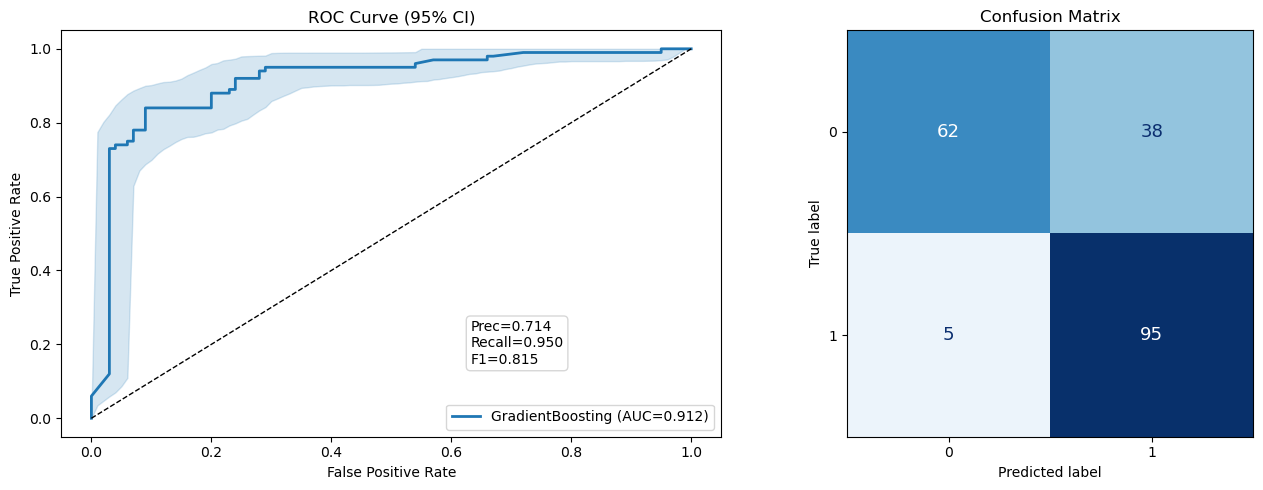

Saved: roc_cm_balanced_100_100_GradientBoosting_blue.png


In [11]:
from sklearn.metrics import (
    roc_curve, auc,
    precision_score, recall_score, f1_score,
    confusion_matrix
)

N_PER_CLASS = 100
model_name = results_df.iloc[0]["model"]  # best by TEST AUC from your pipeline
OUT_PNG = f"roc_cm_balanced_{N_PER_CLASS}_{N_PER_CLASS}_{model_name}_blue.png"

# -------------------------
# 1) Balanced dataframe (100 from each class)
# -------------------------
def sample_n(df_sub, n, seed=RANDOM_STATE):
    """Sample n rows; if not enough, sample with replacement."""
    replace = len(df_sub) < n
    return df_sub.sample(n=n, replace=replace, random_state=seed)

df_familial = sample_n(df[df["class"] == 1], N_PER_CLASS)
df_sporadic = sample_n(df[df["class"] == 0], N_PER_CLASS)

df_balanced = (
    pd.concat([df_familial, df_sporadic], axis=0)
      .sample(frac=1, random_state=RANDOM_STATE)
      .reset_index(drop=True)
)

print("df_balanced shape:", df_balanced.shape)
print("Class counts:\n", df_balanced["class"].value_counts())

X_bal = df_balanced.drop(columns=["class"])
y_bal = df_balanced["class"].astype(int).values

# -------------------------
# 2) Pick best model + use its VAL Youden threshold
# -------------------------
pipe = fitted[model_name]["pipe"]
thr = float(fitted[model_name].get("val_thr", 0.5))

probs = pipe.predict_proba(X_bal)[:, 1]
y_pred = (probs >= thr).astype(int)

# metrics to display (ONLY these)
prec = precision_score(y_bal, y_pred, pos_label=1, zero_division=0)
rec  = recall_score(y_bal, y_pred, pos_label=1, zero_division=0)
f1   = f1_score(y_bal, y_pred, pos_label=1, zero_division=0)

cm = confusion_matrix(y_bal, y_pred, labels=[0, 1])

# -------------------------
# 3) Bootstrap ROC 95% CI
# -------------------------
def bootstrap_roc_ci(y_true, y_prob, n_boot=2000, seed=RANDOM_STATE, n_points=101):
    rng = np.random.default_rng(seed)
    base_fpr = np.linspace(0, 1, n_points)

    tprs = []
    aucs = []
    n = len(y_true)

    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        if len(np.unique(y_true[idx])) < 2:
            continue
        fpr_b, tpr_b, _ = roc_curve(y_true[idx], y_prob[idx])
        aucs.append(auc(fpr_b, tpr_b))

        tpr_interp = np.interp(base_fpr, fpr_b, tpr_b)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    tprs = np.array(tprs)
    tpr_mean = tprs.mean(axis=0)
    tpr_low  = np.percentile(tprs, 2.5, axis=0)
    tpr_high = np.percentile(tprs, 97.5, axis=0)
    return base_fpr, tpr_mean, tpr_low, tpr_high

fpr, tpr, _ = roc_curve(y_bal, probs)
auc_emp = auc(fpr, tpr)
base_fpr, tpr_mean, tpr_low, tpr_high = bootstrap_roc_ci(y_bal, probs)

# -------------------------
# 4) Plot + Save (Blue-only)
# -------------------------
blue = "#1f77b4"
blue_cmap = plt.cm.Blues

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ROC (blue line + blue CI band)
ax1.plot(fpr, tpr, linewidth=2, color=blue, label=f"{model_name} (AUC={auc_emp:.3f})")
ax1.fill_between(base_fpr, tpr_low, tpr_high, color=blue, alpha=0.18)
ax1.plot([0, 1], [0, 1], "k--", linewidth=1)

ax1.set_title("ROC Curve (95% CI)")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")

# ROC box (ONLY Prec/Recall/F1)
ax1.text(
    0.62, 0.18,
    f"Prec={prec:.3f}\nRecall={rec:.3f}\nF1={f1:.3f}",
    transform=ax1.transAxes,
    bbox=dict(boxstyle="round", facecolor="white", edgecolor="lightgray", alpha=0.9)
)

ax1.legend(loc="lower right")

# Confusion Matrix (Blues)
im = ax2.imshow(cm, interpolation="nearest", cmap=blue_cmap, vmin=0, vmax=cm.max())
ax2.set_title("Confusion Matrix")
ax2.set_xlabel("Predicted label")
ax2.set_ylabel("True label")
ax2.set_xticks([0, 1]); ax2.set_yticks([0, 1])
ax2.set_xticklabels([0, 1]); ax2.set_yticklabels([0, 1])

thresh = cm.max() / 2.0
for i in range(2):
    for j in range(2):
        ax2.text(
            j, i, int(cm[i, j]),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "#0b2e6f",
            fontsize=13
        )

plt.tight_layout()
fig.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", OUT_PNG)


## Ablation Study

In [ ]:
FEATURE_RENAME = {
    "Phenotype": "Mouse Phenotype Score (MPS)",
    "gene_score": "Gene Variant Burden Score (GVBS)",
    "PH": "Associated Phenotype Number (APN)",
    "CADD_PHRED": "CADD PHRED Score",
    "Compound_Het_Score": "Digenic Variant Interaction Score (DVIS)",
    "DCs_score": "Protein-Protein Interaction Score (PPIS)",
}


In [ ]:
# =========================
# Ablation study utilities (academic metrics + readable output)
# =========================
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    balanced_accuracy_score,
    matthews_corrcoef,
    f1_score,
)

# Reuse your existing: RANDOM_STATE, CV, youden_threshold, summarise
# Reuse your existing: X_train, X_val, X_test, y_train, y_val, y_test
# Reuse your existing: model_spaces (pipelines + param grids)

# ---------------------------------------------------------
# Bootstrap CI for threshold-dependent metrics (academic)
# ---------------------------------------------------------
def bootstrap_threshold_metric_ci(y_true, probs, thr, metric_fn, n_boot=2000, random_state=42):
    """
    Bootstrap SD + 95% percentile CI for metrics that depend on a fixed threshold.
    metric_fn signature: metric_fn(y_true_sample, y_pred_sample) -> float
    """
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true)
    probs = np.asarray(probs)
    n = len(y_true)

    stats = []
    for _ in range(n_boot):
        idx = rng.choice(np.arange(n), size=n, replace=True)
        y_b = y_true[idx]
        p_b = probs[idx]
        yhat_b = (p_b >= thr).astype(int)
        try:
            stats.append(float(metric_fn(y_b, yhat_b)))
        except Exception:
            continue

    stats = np.asarray(stats, dtype=float)
    if stats.size == 0:
        return {"std": np.nan, "ci": (np.nan, np.nan)}

    return {
        "std": float(np.std(stats, ddof=1)),
        "ci": (float(np.percentile(stats, 2.5)), float(np.percentile(stats, 97.5))),
    }


def _ensure_recommended_metrics(y_true, probs, thr, s_dict, n_boot=2000, random_state=42):
    """
    If summarise() did not provide bal_acc/mcc/f1_1 (and their CIs),
    compute them here and attach to the summary dict.
    """
    y_true = np.asarray(y_true)
    probs = np.asarray(probs)
    yhat = (probs >= thr).astype(int)

    # Balanced Accuracy
    if "bal_acc" not in s_dict:
        s_dict["bal_acc"] = float(balanced_accuracy_score(y_true, yhat))
        s_dict["bal_acc_ci"] = bootstrap_threshold_metric_ci(
            y_true, probs, thr,
            metric_fn=balanced_accuracy_score,
            n_boot=n_boot, random_state=random_state
        )

    # MCC
    if "mcc" not in s_dict:
        s_dict["mcc"] = float(matthews_corrcoef(y_true, yhat))
        s_dict["mcc_ci"] = bootstrap_threshold_metric_ci(
            y_true, probs, thr,
            metric_fn=matthews_corrcoef,
            n_boot=n_boot, random_state=random_state
        )

    # F1 for class 1
    if "f1_1" not in s_dict:
        s_dict["f1_1"] = float(f1_score(y_true, yhat, pos_label=1, zero_division=0))
        s_dict["f1_1_ci"] = bootstrap_threshold_metric_ci(
            y_true, probs, thr,
            metric_fn=lambda yt, yp: f1_score(yt, yp, pos_label=1, zero_division=0),
            n_boot=n_boot, random_state=random_state
        )

    return s_dict


def run_one_setting(model_name, spec, X_train_s, X_val_s, X_test_s, y_train, y_val, y_test,
                    n_boot=2000, random_state=42):
    """
    Fits the model (CV tuning on TRAIN), chooses threshold on VAL (Youden),
    evaluates on TEST using that threshold. Returns a flat dict of academic metrics.
    """
    gs = GridSearchCV(
        estimator=spec["pipe"],
        param_grid=spec["params"],
        scoring="roc_auc",
        cv=CV,
        n_jobs=-1,
        refit=True,
    )
    gs.fit(X_train_s, y_train)
    best_pipe = gs.best_estimator_

    # Validation threshold (Youden)
    val_probs = best_pipe.predict_proba(X_val_s)[:, 1]
    thr = float(youden_threshold(y_val, val_probs))

    # Summaries from your existing function
    s_val = summarise(y_val, val_probs, thr)
    test_probs = best_pipe.predict_proba(X_test_s)[:, 1]
    s_test = summarise(y_test, test_probs, thr)

    # Ensure recommended academic metrics exist (compute if missing)
    s_val = _ensure_recommended_metrics(y_val, val_probs, thr, s_val, n_boot=n_boot, random_state=random_state)
    s_test = _ensure_recommended_metrics(y_test, test_probs, thr, s_test, n_boot=n_boot, random_state=random_state)

    out = {
        "model": model_name,
        "setting_threshold_val_youden": thr,
        "best_params": gs.best_params_,

        # VAL
        "val_auc": s_val["auc"], "val_auc_std": s_val["auc_ci"]["std"], "val_auc_ci": s_val["auc_ci"]["ci"],
        "val_ap": s_val["ap"], "val_ap_std": s_val["ap_ci"]["std"], "val_ap_ci": s_val["ap_ci"]["ci"],
        "val_acc": s_val["acc"], "val_acc_std": s_val["acc_ci"]["std"], "val_acc_ci": s_val["acc_ci"]["ci"],
        "val_prec1": s_val["prec1"], "val_prec1_std": s_val["prec1_ci"]["std"], "val_prec1_ci": s_val["prec1_ci"]["ci"],
        "val_rec1": s_val["rec1"], "val_rec1_std": s_val["rec1_ci"]["std"], "val_rec1_ci": s_val["rec1_ci"]["ci"],
        "val_f1_1": s_val["f1_1"], "val_f1_1_std": s_val["f1_1_ci"]["std"], "val_f1_1_ci": s_val["f1_1_ci"]["ci"],
        "val_bal_acc": s_val["bal_acc"], "val_bal_acc_std": s_val["bal_acc_ci"]["std"], "val_bal_acc_ci": s_val["bal_acc_ci"]["ci"],
        "val_mcc": s_val["mcc"], "val_mcc_std": s_val["mcc_ci"]["std"], "val_mcc_ci": s_val["mcc_ci"]["ci"],
        "val_brier": s_val["brier"], "val_brier_std": s_val["brier_ci"]["std"], "val_brier_ci": s_val["brier_ci"]["ci"],

        # TEST
        "test_auc": s_test["auc"], "test_auc_std": s_test["auc_ci"]["std"], "test_auc_ci": s_test["auc_ci"]["ci"],
        "test_ap": s_test["ap"], "test_ap_std": s_test["ap_ci"]["std"], "test_ap_ci": s_test["ap_ci"]["ci"],
        "test_acc": s_test["acc"], "test_acc_std": s_test["acc_ci"]["std"], "test_acc_ci": s_test["acc_ci"]["ci"],
        "test_prec1": s_test["prec1"], "test_prec1_std": s_test["prec1_ci"]["std"], "test_prec1_ci": s_test["prec1_ci"]["ci"],
        "test_rec1": s_test["rec1"], "test_rec1_std": s_test["rec1_ci"]["std"], "test_rec1_ci": s_test["rec1_ci"]["ci"],
        "test_f1_1": s_test["f1_1"], "test_f1_1_std": s_test["f1_1_ci"]["std"], "test_f1_1_ci": s_test["f1_1_ci"]["ci"],
        "test_bal_acc": s_test["bal_acc"], "test_bal_acc_std": s_test["bal_acc_ci"]["std"], "test_bal_acc_ci": s_test["bal_acc_ci"]["ci"],
        "test_mcc": s_test["mcc"], "test_mcc_std": s_test["mcc_ci"]["std"], "test_mcc_ci": s_test["mcc_ci"]["ci"],
        "test_brier": s_test["brier"], "test_brier_std": s_test["brier_ci"]["std"], "test_brier_ci": s_test["brier_ci"]["ci"],
    }
    return out


def ablation_study(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    model_spaces,
    base_feature_set=None,
    ablation_map=None,
    run_models=None,
):
    """
    Runs baseline + ablations.
    - base_feature_set: list of columns to use (default = all columns)
    - ablation_map: dict[name -> list_of_columns_to_drop]
    - run_models: list of model names to run (default = all in model_spaces)
    """
    if base_feature_set is None:
        base_feature_set = list(X_train.columns)

    if run_models is None:
        run_models = list(model_spaces.keys())

    if ablation_map is None:
        ablation_map = {f"drop__{c}": [c] for c in base_feature_set}

    records = []

    # Baseline
    baseline_cols = base_feature_set
    for m in run_models:
        rec = run_one_setting(
            model_name=m,
            spec=model_spaces[m],
            X_train_s=X_train[baseline_cols],
            X_val_s=X_val[baseline_cols],
            X_test_s=X_test[baseline_cols],
            y_train=y_train, y_val=y_val, y_test=y_test
        )
        rec.update({"setting": "baseline", "dropped": "", "n_features": len(baseline_cols)})
        records.append(rec)

    # Ablations
    for setting_name, drop_cols in ablation_map.items():
        cols = [c for c in base_feature_set if c not in set(drop_cols)]
        for m in run_models:
            rec = run_one_setting(
                model_name=m,
                spec=model_spaces[m],
                X_train_s=X_train[cols],
                X_val_s=X_val[cols],
                X_test_s=X_test[cols],
                y_train=y_train, y_val=y_val, y_test=y_test
            )
            rec.update({"setting": setting_name, "dropped": ", ".join(drop_cols), "n_features": len(cols)})
            records.append(rec)

    df_ab = pd.DataFrame(records)

    # Deltas vs baseline (per model)
    base = df_ab[df_ab["setting"] == "baseline"][[
        "model",
        "test_auc", "test_ap", "test_acc", "test_rec1", "test_prec1",
        "test_f1_1", "test_bal_acc", "test_mcc", "test_brier"
    ]].copy()

    base = base.rename(columns={
        "test_auc": "base_test_auc",
        "test_ap": "base_test_ap",
        "test_acc": "base_test_acc",
        "test_rec1": "base_test_rec1",
        "test_prec1": "base_test_prec1",
        "test_f1_1": "base_test_f1_1",
        "test_bal_acc": "base_test_bal_acc",
        "test_mcc": "base_test_mcc",
        "test_brier": "base_test_brier",
    })

    df_ab = df_ab.merge(base, on="model", how="left")
    for k in ["auc", "ap", "acc", "rec1", "prec1", "f1_1", "bal_acc", "mcc", "brier"]:
        df_ab[f"delta_test_{k}"] = df_ab[f"test_{k}"] - df_ab[f"base_test_{k}"]

    # Sort by largest AUC drop (most harmful)
    df_ab = df_ab.sort_values(["model", "delta_test_auc"], ascending=[True, True])

    return df_ab


# =========================
# Readable academic output helpers
# =========================
def fmt_est_ci(est, ci, ndp=3):
    if est is None or (isinstance(est, float) and np.isnan(est)):
        return ""
    lo, hi = ci
    return f"{est:.{ndp}f} [{lo:.{ndp}f}, {hi:.{ndp}f}]"

def make_academic_table(df_ablation, ndp=3):
    df = df_ablation.copy()

    # Create compact "estimate [CI]" columns
    for m in ["auc", "ap", "acc", "prec1", "rec1", "f1_1", "bal_acc", "mcc", "brier"]:
        if f"test_{m}" in df.columns and f"test_{m}_ci" in df.columns:
            df[f"TEST_{m.upper()}"] = [
                fmt_est_ci(est, ci, ndp=ndp) for est, ci in zip(df[f"test_{m}"], df[f"test_{m}_ci"])
            ]

    # Deltas (keep numeric, rounded)
    for m in ["auc", "ap", "acc", "rec1", "prec1", "f1_1", "bal_acc", "mcc", "brier"]:
        col = f"delta_test_{m}"
        if col in df.columns:
            df[col] = df[col].astype(float).round(ndp)

    cols = [
        "model", "setting", "dropped", "n_features",
        "TEST_AUC", "delta_test_auc",
        "TEST_AP", "delta_test_ap",
        "TEST_REC1", "delta_test_rec1",
        "TEST_PREC1", "delta_test_prec1",
        "TEST_F1_1", "delta_test_f1_1",
        "TEST_BAL_ACC", "delta_test_bal_acc",
        "TEST_MCC", "delta_test_mcc",
        "TEST_BRIER", "delta_test_brier",
        "setting_threshold_val_youden",
    ]
    cols = [c for c in cols if c in df.columns]
    return df[cols]


# =========================
# EXAMPLE USAGE
# =========================
ablation_groups = {
    "drop__cadd_only": ["CADD_PHRED"],
    "drop__compound_het": ["Compound_Het_Score"],
    "drop__phenotype_block": ["Phenotype", "PH"],
    "drop__gene_score": ["gene_score"],
    "drop__dcs_score": ["DCs_score"],
}

# Keep only columns that exist
existing_cols = set(X_train.columns)
ablation_groups = {k: [c for c in v if c in existing_cols] for k, v in ablation_groups.items()}
ablation_groups = {k: v for k, v in ablation_groups.items() if len(v) > 0}

models_to_run = ["GradientBoosting"]  # or list(model_spaces.keys())

df_ablation = ablation_study(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    model_spaces=model_spaces,
    ablation_map=ablation_groups,
    run_models=models_to_run
)

# Print academic, readable table
pd.set_option("display.max_colwidth", 120)
table = make_academic_table(df_ablation, ndp=3)
print(table.to_string(index=False))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Updated paper/figure names
# =========================
FEATURE_RENAME = {
    "Phenotype": "Mouse Phenotype Score (MPS)",
    "gene_score": "Gene Variant Burden Score (GVBS)",
    "PH": "Associated Phenotype Number (APN)",
    "CADD_PHRED": "CADD PHRED Score",
    "Compound_Het_Score": "Digenic Variant Interaction Score (DVIS)",
    "DCs_score": "Protein-Protein Interaction Score (PPIS)",
}

# Setting-name mapping (your ablation_groups keys)
SETTING_RENAME = {
    "drop__cadd_only": "Drop: CADD PHRED Score",
    "drop__compound_het": "Drop: DVIS",
    "drop__gene_score": "Drop: GVBS",
    "drop__dcs_score": "Drop: PPIS",
    # Two-feature block
    "drop__phenotype_block": "Drop: MPS + APN",
    "baseline": "all features",
}

# ----------------------------
# Helper: convert (low, high) CI tuple -> yerr array for plt.errorbar
# ----------------------------
def ci_to_yerr(estimates, ci_series):
    ci = np.vstack(ci_series.apply(lambda x: np.array(x, dtype=float)).values)  # (n,2)
    lower = estimates - ci[:, 0]
    upper = ci[:, 1] - estimates
    return np.vstack([lower, upper])

# ----------------------------
# Pretty label for each ablation row
# ----------------------------
def pretty_setting_from_row(setting: str, dropped: str) -> str:
    # First try explicit setting key mapping (works for your grouped ablations)
    if setting in SETTING_RENAME:
        return SETTING_RENAME[setting]

    # Fallback: if it's "drop__<single_feature>" style, map via FEATURE_RENAME
    if isinstance(setting, str) and setting.startswith("drop__"):
        raw = setting.replace("drop__", "").strip()
        nice = FEATURE_RENAME.get(raw, raw)
        return f"Drop: {nice}"

    # Fallback for anything else
    return str(setting)

# ----------------------------
# Pick the model and build plotting df
# ----------------------------
df = df_ablation.copy()
model_name = df["model"].iloc[0]
dfm = df[df["model"] == model_name].copy()

# Build pretty labels using both "setting" and "dropped"
dfm["setting_pretty"] = [
    pretty_setting_from_row(s, d) for s, d in zip(dfm["setting"], dfm.get("dropped", [""]*len(dfm)))
]

# Sort: most harmful (lowest delta AUC) at top
dfm = dfm.sort_values("delta_test_auc", ascending=True)

# ----------------------------
# Output paths
# ----------------------------
out1 = f"ablation_delta_auc_{model_name}.png"
out2 = f"ablation_test_auc_ci_{model_name}.png"
out3 = f"ablation_delta_heatmap_{model_name}.png"
out_csv = f"ablation_summary_{model_name}.csv"

# ----------------------------
# Plot 1: Δ Test ROC-AUC vs baseline (barh)
# ----------------------------
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.barh(dfm["setting_pretty"], dfm["delta_test_auc"])
ax.axvline(0, linewidth=1)
ax.set_xlabel("Δ Test ROC-AUC vs baseline")
ax.set_title(f"Ablation impact on discrimination (Model: {model_name})")
plt.tight_layout()
plt.savefig(out1, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f"Saved: {out1}")

# ----------------------------
# Plot 2: Test ROC-AUC with 95% CI (error bars)
# ----------------------------
x = np.arange(len(dfm))
auc = dfm["test_auc"].astype(float).values
yerr = ci_to_yerr(auc, dfm["test_auc_ci"])

fig, ax = plt.subplots(figsize=(9, 4.5))
ax.errorbar(x, auc, yerr=yerr, fmt="o", capsize=4)
ax.set_xticks(x)
ax.set_xticklabels(dfm["setting_pretty"], rotation=35, ha="right")
ax.set_ylabel("Test ROC-AUC")
ax.set_title(f"Test ROC-AUC with 95% bootstrap CI (Model: {model_name})")
ax.set_ylim(0, 1)
plt.tight_layout()
plt.savefig(out2, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f"Saved: {out2}")

# ----------------------------
# Plot 3: Multi-metric Δ heatmap (AUC/AP/BalAcc/MCC/Brier)
# ----------------------------
metrics = ["auc", "ap", "bal_acc", "mcc", "brier"]
delta_cols = [f"delta_test_{m}" for m in metrics]

M = dfm[delta_cols].astype(float).values
max_abs = np.nanmax(np.abs(M)) if np.isfinite(M).any() else 1.0

fig, ax = plt.subplots(figsize=(9, 0.55 * len(dfm) + 2))
im = ax.imshow(M, aspect="auto", vmin=-max_abs, vmax=max_abs)
ax.set_xticks(np.arange(len(metrics)))
ax.set_xticklabels([f"Δ {m.upper()}" for m in metrics], rotation=35, ha="right")
ax.set_yticks(np.arange(len(dfm)))
ax.set_yticklabels(dfm["setting_pretty"])
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Δ vs baseline")
ax.set_title(f"Ablation deltas across metrics (Model: {model_name})")
plt.tight_layout()
plt.savefig(out3, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f"Saved: {out3}")

# ----------------------------
# Save a compact table (with the updated names)
# ----------------------------
display_cols = [
    "model", "setting_pretty", "n_features",
    "test_auc", "test_auc_ci", "delta_test_auc",
    "test_ap", "test_ap_ci", "delta_test_ap",
    "test_bal_acc", "test_bal_acc_ci", "delta_test_bal_acc",
    "test_mcc", "test_mcc_ci", "delta_test_mcc",
    "test_brier", "test_brier_ci", "delta_test_brier",
    "setting_threshold_val_youden"
]
display_cols = [c for c in display_cols if c in dfm.columns]

dfm[display_cols].to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")

print(dfm[display_cols].to_string(index=False))
